# Modules

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pylab import rcParams
# For Sarimax
import itertools
import warnings

# Variables and parameters

In [2]:
CSV_PATH='/home/nicolaesse/TennisTimeSerie/Values_2011_2018.csv'
plt.style.use('fast')

# Data reading

Load the data into a DataFrame. 
fillna and bfill are used to be sure that there's no empty values between first and last day.

In [3]:
RacketsDF = pd.read_csv(CSV_PATH,sep=";")
RacketsDF = RacketsDF.fillna(RacketsDF.bfill())

# EDA and TS analysis

In [4]:
RacketsDF.shape

(87, 2)

In [5]:
RacketsDF.head()

,Month,Val
0,01/10/2011,33
1,01/11/2011,30
2,01/12/2011,33
3,01/01/2012,39
4,01/02/2012,39


In [6]:
RacketsDF.dtypes

Month    object
Val       int64
dtype: object

We have to transform the DataFrame because we need a DatetimeIndex. 

In [7]:
RacketsDF['DateTime'] = RacketsDF['Month'].apply(lambda x: pd.to_datetime(str(x), format='%d/%m/%Y'))
RacketsDF = RacketsDF.set_index(pd.DatetimeIndex(RacketsDF['DateTime']))
RacketsDF = RacketsDF.drop(['Month','DateTime'], axis=1)
RacketsDF.dtypes

Val    int64
dtype: object

In [8]:
RacketsDF.head()

,Val
DateTime,
2011-10-01,33
2011-11-01,30
2011-12-01,33
2012-01-01,39
2012-02-01,39


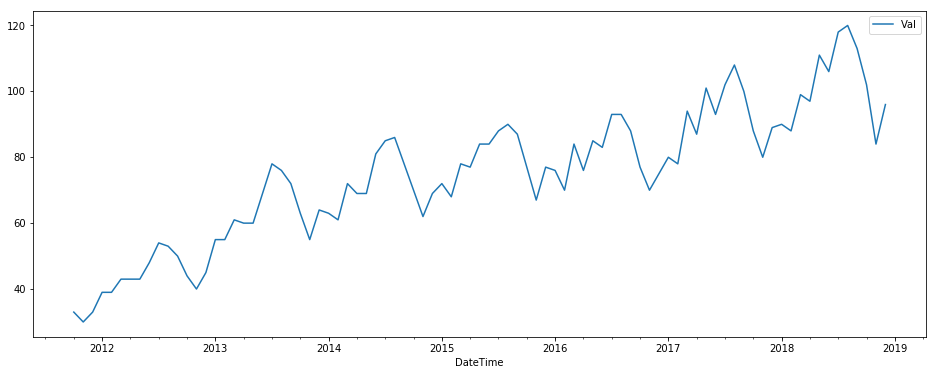

In [9]:
RacketsDF.plot(figsize=(16, 6))
plt.show()

In [10]:
RacketsDF.describe()

,Val
count,87.000000
mean,74.862069
std,20.538207
min,30.000000
25%,61.500000
50%,77.000000
75%,88.000000
max,120.000000


In [11]:
RacketsDF['2018':]

,Val
DateTime,
2018-01-01,90
2018-02-01,88
2018-03-01,99
2018-04-01,97
2018-05-01,111
2018-06-01,106
2018-07-01,118
2018-08-01,120
2018-09-01,113


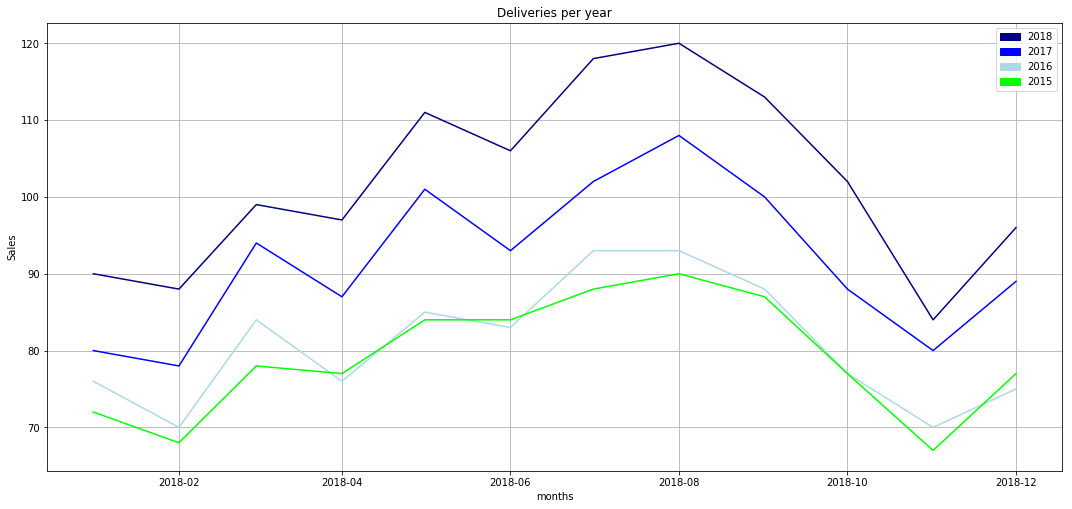

In [12]:
fig, ax1 = plt.subplots(figsize=(15,7))
months = RacketsDF['2018'].index
ax1.set_xlabel('months')
ax1.set_ylabel('Sales')
ax1.plot(months, RacketsDF['2018'], color='navy')
ax1.plot(months, RacketsDF['2017'], color='blue')
ax1.plot(months, RacketsDF['2016'], color='lightblue')
ax1.plot(months, RacketsDF['2015'], color='lime')
plt.grid()

leg_2018 = mpatches.Patch(color='navy', label='2018')
leg_2017 = mpatches.Patch(color='blue', label='2017')
leg_2016 = mpatches.Patch(color='lightblue', label='2016')
leg_2015 = mpatches.Patch(color='lime', label='2015')
plt.legend(handles=[leg_2018,leg_2017,leg_2016,leg_2015])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Deliveries per year', loc='center')

plt.show()

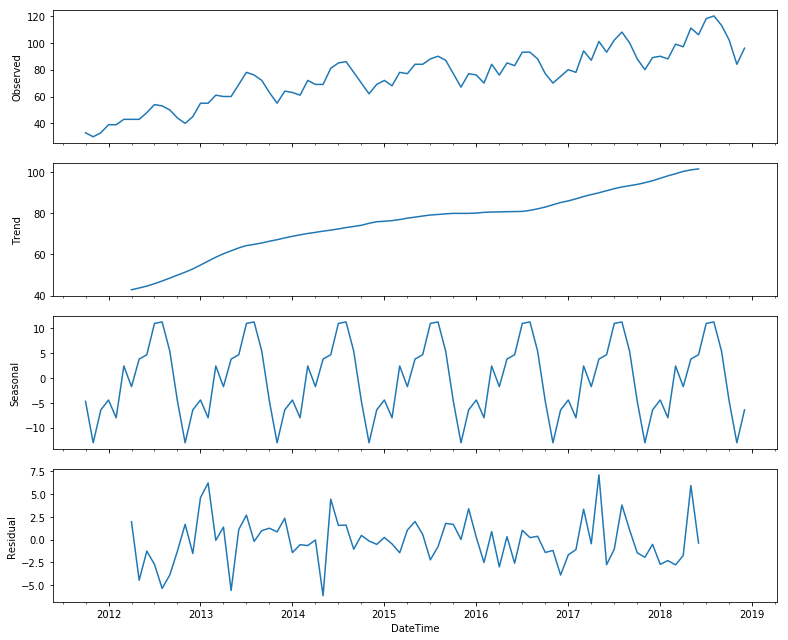

In [13]:
rcParams['figure.figsize'] = 11, 9

RacketsDF_decomp = sm.tsa.seasonal_decompose(RacketsDF, model='additive')
fig = RacketsDF_decomp.plot()
plt.show()

# Dickey-Fuller Test

From the plots above plot above it is easy to understand that the TS is not stationary but we also want an analytic test to prove it.

In [14]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic          -1.622820
p-value                  0.471251
Lags Used               12.000000
Observations Used       74.000000
Critical Value (1%)     -3.521980
Critical Value (5%)     -2.901470
Critical Value (10%)    -2.588072
dtype: float64


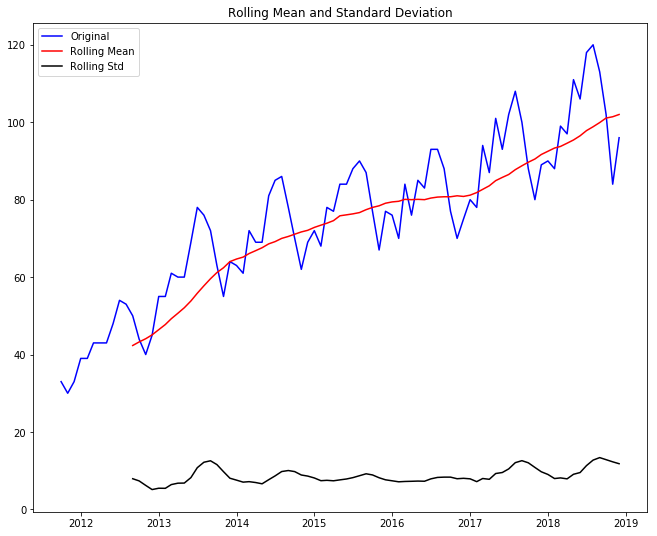

In [15]:
dftest(RacketsDF.Val)

# SARIMAX model

In [16]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

listAIC = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(RacketsDF,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 -> AIC:{}'.format(param, param_seasonal, results.aic))
            listAIC.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 -> AIC:995.3357044938019
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 -> AIC:798.2371211915685
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 -> AIC:569.1619943484142
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 -> AIC:428.6041512221132
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 -> AIC:509.1914035709319
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 -> AIC:504.16675849585926
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 -> AIC:419.52735652848054
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 -> AIC:407.5079790401004
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 -> AIC:884.7931318960173
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 -> AIC:703.298050945478
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 -> AIC:502.3311281432382
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 -> AIC:389.56574792636144
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 -> AIC:467.33781056104476
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 -> AIC:457.8744086490895
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 -> AIC:397.55881155427346
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 -> AIC:376.0004306170067
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 -> AIC:584.260027893246
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 -> AIC:470.701

In [17]:
listAIC.sort()
print(listAIC[0])

329.6331660694662


In [18]:
# ARIMA(0, 1, 1)x(0, 1, 1, 12)12
# AIC:329.6331660694662

# Model quality evaluation

In [19]:
mod = sm.tsa.statespace.SARIMAX(RacketsDF,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4683      0.111     -4.223      0.000      -0.686      -0.251
ma.S.L12      -0.3224      0.133     -2.416      0.016      -0.584      -0.061
sigma2        12.8575      2.251      5.712      0.000       8.445      17.270


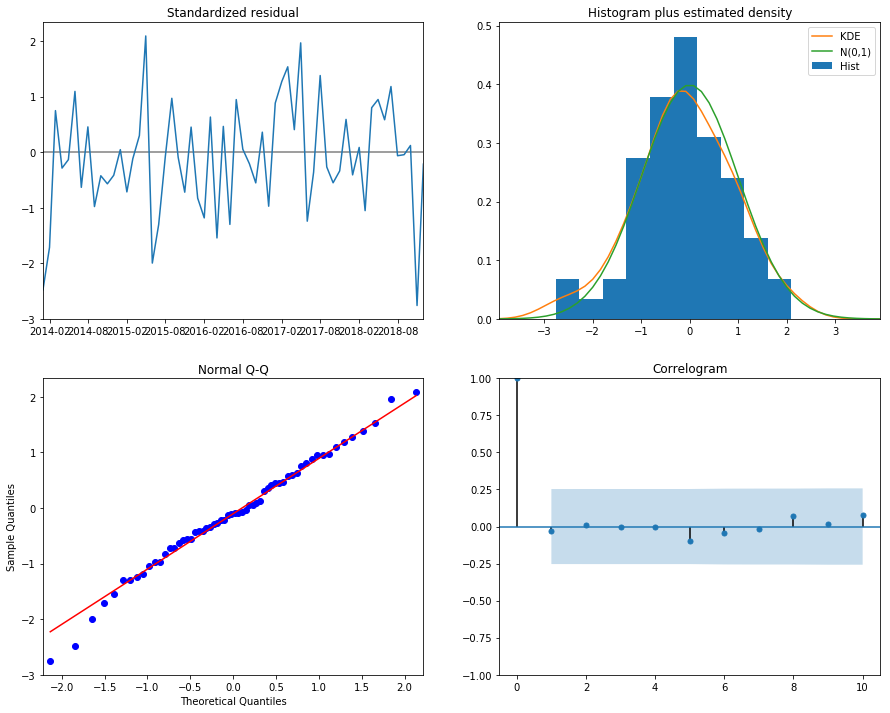

In [20]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [21]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_confidence = pred.conf_int()

In [22]:
pred.predicted_mean

2018-01-01     91.461548
2018-02-01     87.691134
2018-03-01    102.768814
2018-04-01     94.127564
2018-05-01    107.600924
2018-06-01    103.907136
2018-07-01    113.762841
2018-08-01    120.226905
2018-09-01    113.159699
2018-10-01    101.566658
2018-11-01     93.888829
2018-12-01     96.766583
Freq: MS, dtype: float64

In [23]:
pred_confidence

,lower Val,upper Val
2018-01-01,84.433643,98.489454
2018-02-01,80.663230,94.719039
2018-03-01,95.740910,109.796718
2018-04-01,87.099660,101.155468
2018-05-01,100.573020,114.628828
2018-06-01,96.879232,110.935040
2018-07-01,106.734937,120.790745
2018-08-01,113.199001,127.254809
2018-09-01,106.131795,120.187603
2018-10-01,94.538754,108.594562


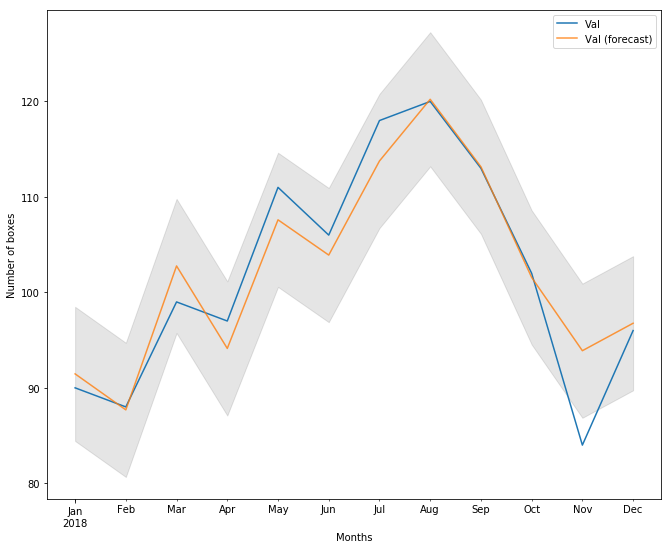

In [24]:
# plot predictions
ax = RacketsDF['2018-01-01':].plot(label='Number of boxes')
pred.predicted_mean.plot(ax=ax, label='Val (forecast)', alpha=.8)
ax.fill_between(pred_confidence.index, pred_confidence.iloc[:, 0], pred_confidence.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Months')
ax.set_ylabel('Number of boxes')
plt.legend()

plt.show();

In [25]:
RacketsDF_forecasted = pred.predicted_mean
RacketsDF_true = RacketsDF['2018-01-01':]['Val']

mse = ((RacketsDF_forecasted - RacketsDF_true) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 13.1


In [26]:
RacketsDF_forecasted=RacketsDF_forecasted.round(0)
pd.concat([RacketsDF_true.rename('RacketsDF_true'), RacketsDF_forecasted.rename('RacketsDF_forecasted')], axis=1)

,RacketsDF_true,RacketsDF_forecasted
DateTime,,
2018-01-01,90,91.0
2018-02-01,88,88.0
2018-03-01,99,103.0
2018-04-01,97,94.0
2018-05-01,111,108.0
2018-06-01,106,104.0
2018-07-01,118,114.0
2018-08-01,120,120.0
2018-09-01,113,113.0


# Predicition of 2019

In [27]:
# Let forcast the following 24 months
pred_uc = results.get_forecast(steps=24)
pred_confidence = pred_uc.conf_int()

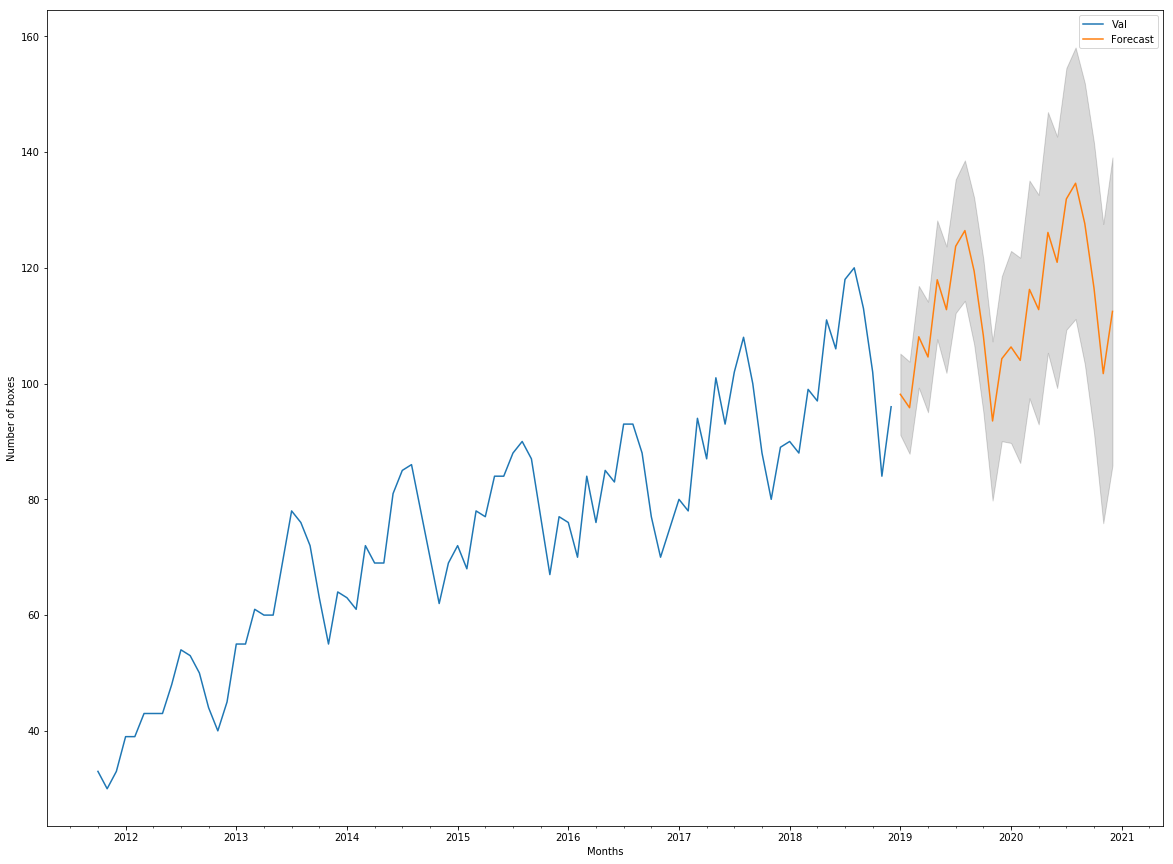

In [28]:
ax = RacketsDF.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_confidence.index,
                pred_confidence.iloc[:, 0],
                pred_confidence.iloc[:, 1], color='k', alpha=.15)
ax.set_xlabel('Months')
ax.set_ylabel('Number of boxes')

plt.legend()
plt.show()

In [29]:
pred_uc.predicted_mean['2019'].round(0)

2019-01-01     98.0
2019-02-01     96.0
2019-03-01    108.0
2019-04-01    105.0
2019-05-01    118.0
2019-06-01    113.0
2019-07-01    124.0
2019-08-01    126.0
2019-09-01    119.0
2019-10-01    108.0
2019-11-01     94.0
2019-12-01    104.0
Freq: MS, dtype: float64

In [30]:
pred_uc.predicted_mean['2019'].sum().round(0)

1313.0

# Bibliography and sitography

https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
https://github.com/ultimatist/ODSC17/blob/master/Time%20Series%20with%20Python%20(ODSC)%20STA.ipynb